# US Stock Market Prediction (2014-2018)
**Authors:** David PAGNIEZ, Antoine KRYCHOWSKI, Gregoire MEHAH

## 1. Project Objective
The goal of this project is to analyze financial indicators of US companies from 2014 to 2018 and build a machine learning model to predict stock performance.

Our approach follows these steps:
1.  **Data Cleaning:** Handling missing values and outliers in financial data.
2.  **Baseline Model:** Attempting to predict the exact price variation (Regression).
3.  **Classification:** Switching to a trend prediction (Buy/Sell) if regression fails.
4.  **Optimization:** Using Feature Engineering and Ensemble methods to improve results.


In [1]:
# %% Imports
import os
import csv
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import clone

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, classification_report,
    confusion_matrix, roc_auc_score,
    r2_score, mean_absolute_error,
    roc_curve, precision_recall_curve, auc
)
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, VotingClassifier
)

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, StratifiedKFold, cross_validate

# Global Configuration
plt.style.use("ggplot")
sns.set_context("notebook")

RANDOM_STATE = 42
YEARS = [2014, 2015, 2016, 2017, 2018]
DATA_DIR = "." 

In [2]:
# %%
def read_csv_robust(path):
    """
    Attempts to read CSV using ',' and ';' separators.
    Returns the dataframe with the most columns.
    """
    best_df = None
    best_sep = None
    best_ncols = -1

    for sep in [",", ";"]:
        try:
            df = pd.read_csv(path, sep=sep, engine="python")
            if df.shape[1] > best_ncols:
                best_df = df
                best_sep = sep
                best_ncols = df.shape[1]
        except Exception:
            continue

    if best_df is None:
        raise ValueError(f"Unable to read file: {path}")

    return best_df, best_sep


def load_yearly_csvs(years, data_dir="."):
    dfs = []
    for y in years:
        path = os.path.join(data_dir, f"{y}_Financial_Data.csv")
        if not os.path.exists(path):
            raise FileNotFoundError(f"Missing file: {path}")

        df, sep = read_csv_robust(path)
        df["Year"] = y
        print(f"Loaded {os.path.basename(path)} (sep='{sep}') -> shape {df.shape}")
        dfs.append(df)

    data = pd.concat(dfs, ignore_index=True)

    # Drop common artifact index columns
    for c in ["Unnamed: 0", "Unnamed: 0.1"]:
        if c in data.columns:
            data = data.drop(columns=[c])

    print("Final loaded shape:", data.shape)
    return data


def clean_colname(c):
    if not isinstance(c, str):
        return c
    c = c.replace("\ufeff", "")   # Remove potential BOM
    c = c.replace('"', "").strip()
    c = " ".join(c.split())       # Collapse multiple spaces
    return c


# %%
# Data Loading
data = load_yearly_csvs(YEARS, DATA_DIR)
data.columns = [clean_colname(c) for c in data.columns]

# Drop "ghost" columns if present (starting with ;)
ghost_cols = [c for c in data.columns if isinstance(c, str) and c.strip().startswith(";")]
if ghost_cols:
    print(f"Dropping {len(ghost_cols)} ghost col(s). Example:", ghost_cols[0])
    data = data.drop(columns=ghost_cols)

print("After cleanup:", data.shape)

# %%
# Target Creation and Initial Cleaning
price_var_cols = [c for c in data.columns if isinstance(c, str) and "PRICE VAR" in c.upper()]
if not price_var_cols:
    raise ValueError("No 'PRICE VAR' column found.")

def target_col_for_year(y: int) -> str:
    return f"{y+1} PRICE VAR [%]"

data2 = data.copy()
data2["Target_Price_Var"] = np.nan

for y in sorted(data2["Year"].unique()):
    col = target_col_for_year(int(y))
    if col in data2.columns:
        mask = data2["Year"] == y
        data2.loc[mask, "Target_Price_Var"] = pd.to_numeric(data2.loc[mask, col], errors="coerce")

print("Target null rate:", data2["Target_Price_Var"].isna().mean())

# Anti-leakage: drop all original PRICE VAR columns
data2 = data2.drop(columns=price_var_cols)

# Drop "Class" column if it exists (redundant)
if "Class" in data2.columns:
    data2 = data2.drop(columns=["Class"])

# Filtering and Clipping
data_clean = data2.dropna(subset=["Target_Price_Var"]).copy()

# Clip target outliers
data_clean["Target_Price_Var"] = data_clean["Target_Price_Var"].clip(lower=-99, upper=500)

# Drop columns with excessive missing values (>40% NA)
threshold = 0.40
min_non_na = int(len(data_clean) * (1 - threshold))
data_clean = data_clean.dropna(axis=1, thresh=min_non_na)

# Create Binary Target
data_clean["Target_Buy"] = (data_clean["Target_Price_Var"] > 0).astype(int)

# Defragment dataframe to avoid performance warnings
data_clean = data_clean.copy()

print("Shape clean:", data_clean.shape)
print("Buy rate:", data_clean["Target_Buy"].mean().round(4))


Loaded 2014_Financial_Data.csv (sep=';') -> shape (3808, 227)
Loaded 2015_Financial_Data.csv (sep=';') -> shape (4120, 226)
Loaded 2016_Financial_Data.csv (sep=',') -> shape (4797, 226)
Loaded 2017_Financial_Data.csv (sep=',') -> shape (4960, 226)
Loaded 2018_Financial_Data.csv (sep=',') -> shape (4392, 226)
Final loaded shape: (22077, 231)
After cleanup: (22077, 231)
Target null rate: 0.0
Shape clean: (22077, 218)
Buy rate: 0.5499


=== DEEP DATA EXPLORATION ===
Cleaned dataset shape: (22077, 218)
Period: 2014 - 2018
Number of numeric features (including targets/Year): 216

--- Target Variable Distribution (Target_Price_Var) ---


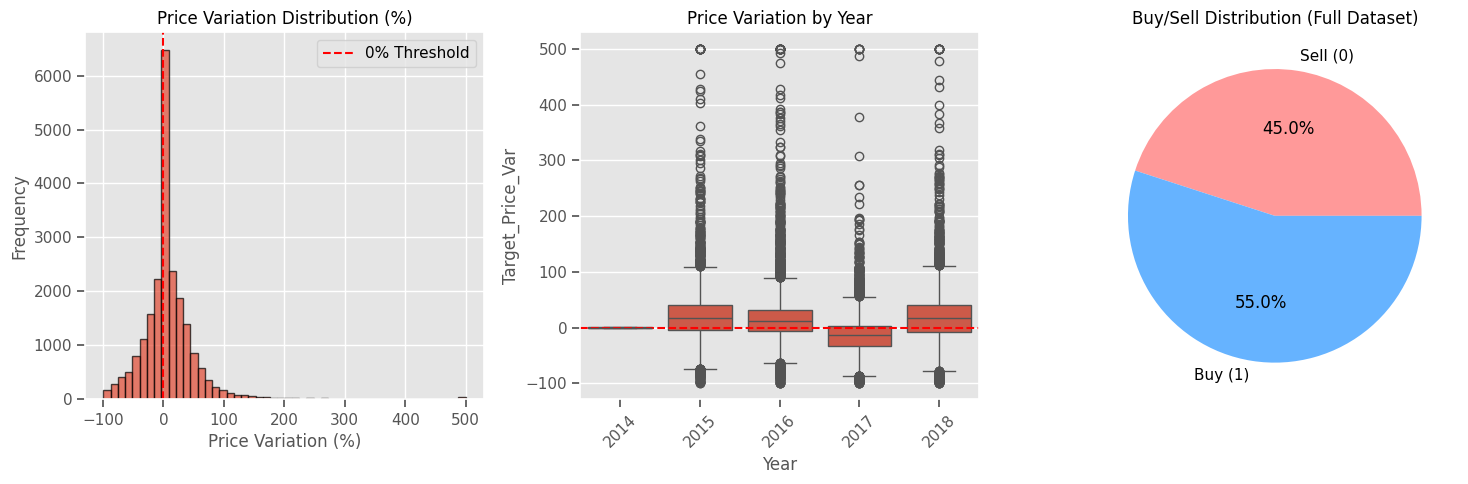


--- Sector Analysis (Top Sectors) ---


C:\Users\antoi\AppData\Local\Temp\ipykernel_24664\494541827.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sector_counts_top.values, y=sector_counts_top.index, ax=axes[0], palette="viridis")
C:\Users\antoi\AppData\Local\Temp\ipykernel_24664\494541827.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sector_perf_top.values, y=sector_perf_top.index, ax=axes[1], palette="coolwarm")


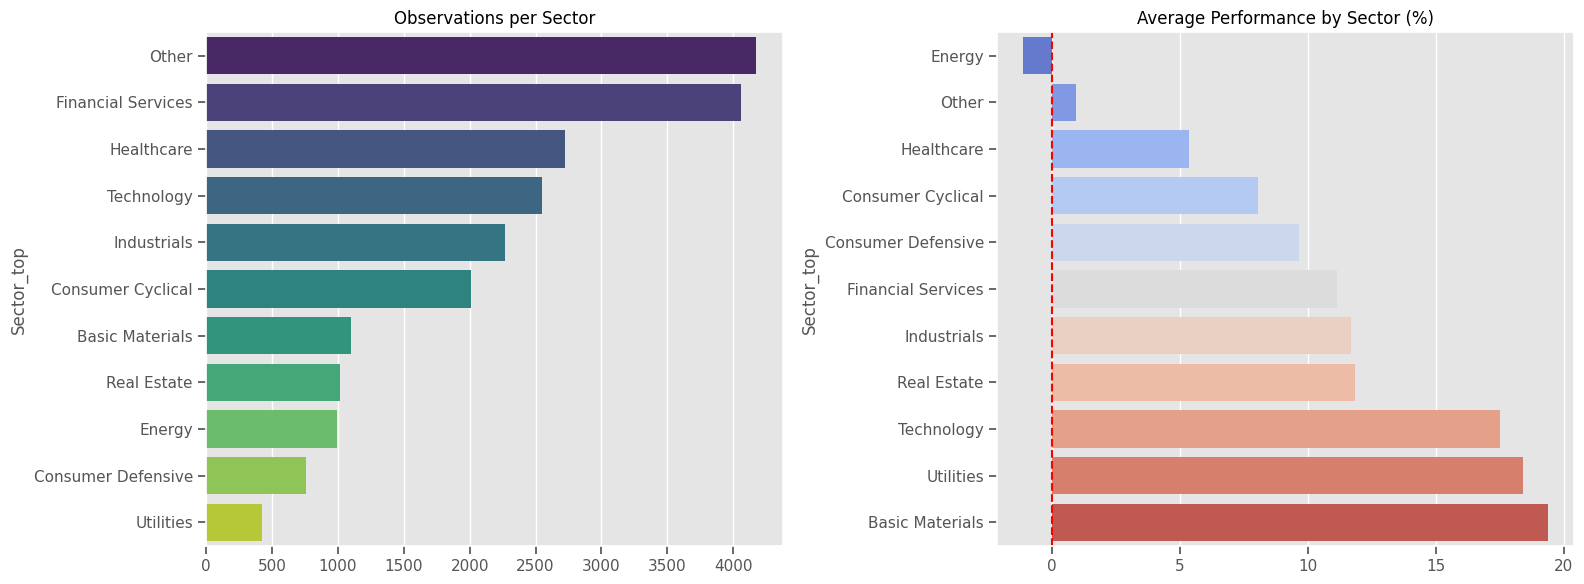


--- Correlations with Target_Price_Var (Numeric) ---


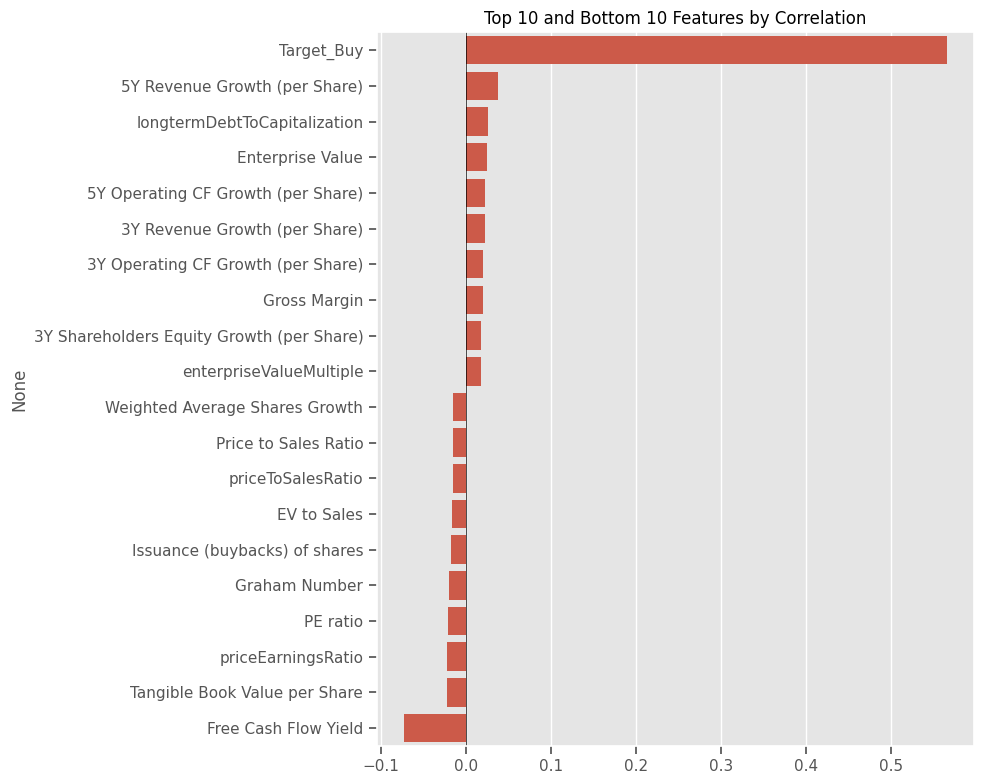

In [3]:
# %%
print("=== DEEP DATA EXPLORATION ===")
print(f"Cleaned dataset shape: {data_clean.shape}")
print(f"Period: {data_clean['Year'].min()} - {data_clean['Year'].max()}")

# Numeric columns
numeric_cols = data_clean.select_dtypes(include=np.number).columns.tolist()
print(f"Number of numeric features (including targets/Year): {len(numeric_cols)}")

print("\n--- Target Variable Distribution (Target_Price_Var) ---")

plt.figure(figsize=(15, 5))

# 1) Histogram Target_Price_Var
plt.subplot(1, 3, 1)
plt.hist(data_clean["Target_Price_Var"].dropna(), bins=50, edgecolor="black", alpha=0.7)
plt.title("Price Variation Distribution (%)")
plt.xlabel("Price Variation (%)")
plt.ylabel("Frequency")
plt.axvline(x=0, color="red", linestyle="--", label="0% Threshold")
plt.legend()

# 2) Boxplot by Year
plt.subplot(1, 3, 2)
sns.boxplot(x="Year", y="Target_Price_Var", data=data_clean)
plt.title("Price Variation by Year")
plt.xticks(rotation=45)
plt.axhline(y=0, color="red", linestyle="--")

# 3) Pie chart Buy/Sell
plt.subplot(1, 3, 3)
binary_target = data_clean["Target_Buy"]
binary_counts = binary_target.value_counts().sort_index()

plt.pie(
    binary_counts.values,
    labels=["Sell (0)", "Buy (1)"],
    autopct="%1.1f%%",
    colors=["#ff9999", "#66b3ff"]
)
plt.title("Buy/Sell Distribution (Full Dataset)")

plt.tight_layout()
plt.show()

# Sector Analysis
if "Sector" in data_clean.columns:
    print("\n--- Sector Analysis (Top Sectors) ---")
    df_sec = data_clean.copy()
    df_sec["Sector"] = df_sec["Sector"].astype(str).str.strip()
    df_sec.loc[df_sec["Sector"].isin(["", "nan", "None"]), "Sector"] = np.nan
    df_sec = df_sec.dropna(subset=["Sector"])

    TOP_N = 10
    sector_counts = df_sec["Sector"].value_counts()
    top_sectors = sector_counts.head(TOP_N).index
    df_sec["Sector_top"] = np.where(df_sec["Sector"].isin(top_sectors), df_sec["Sector"], "Other")

    sector_counts_top = df_sec["Sector_top"].value_counts()
    sector_perf_top = df_sec.groupby("Sector_top")["Target_Price_Var"].mean().sort_values()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.barplot(x=sector_counts_top.values, y=sector_counts_top.index, ax=axes[0], palette="viridis")
    axes[0].set_title(f"Observations per Sector")
    sns.barplot(x=sector_perf_top.values, y=sector_perf_top.index, ax=axes[1], palette="coolwarm")
    axes[1].axvline(x=0, color="red", linestyle="--")
    axes[1].set_title(f"Average Performance by Sector (%)")
    plt.tight_layout()
    plt.show()

# Correlations
print("\n--- Correlations with Target_Price_Var (Numeric) ---")
corr_df = data_clean.select_dtypes(include=np.number).copy()
all_nan_cols = [c for c in corr_df.columns if corr_df[c].isna().all()]
if all_nan_cols:
    corr_df = corr_df.drop(columns=all_nan_cols)

correlation_matrix = corr_df.corr(numeric_only=True)

if "Target_Price_Var" in correlation_matrix.columns:
    target_corr = correlation_matrix["Target_Price_Var"].drop(labels=["Target_Price_Var"], errors="ignore").sort_values(ascending=False)
    top_corr = target_corr.head(10)
    bottom_corr = target_corr.tail(10)
    combined_corr = pd.concat([top_corr, bottom_corr])

    plt.figure(figsize=(10, 8))
    sns.barplot(x=combined_corr.values, y=combined_corr.index)
    plt.title("Top 10 and Bottom 10 Features by Correlation")
    plt.axvline(x=0, color="black", linestyle="-", linewidth=0.5)
    plt.tight_layout()
    plt.show()


Train shape: (17685, 218) | Test shape: (4392, 218)
Train buy rate: 0.5146 | Test buy rate: 0.6919


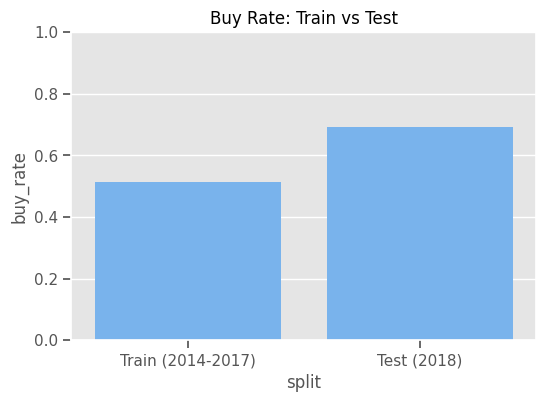

Winsorization features: done.
RAW features: 213
ENGINEERED features: ['ROE_calc', 'Net_Margin_calc', 'Debt_to_Equity_calc', 'EPS', 'EBITDA', 'Operating Cash Flow', 'Market Cap']


In [4]:
# %%
# Temporal Split
train_df = data_clean[data_clean["Year"].isin([2014, 2015, 2016, 2017])].copy()
test_df  = data_clean[data_clean["Year"] == 2018].copy()

y_train = train_df["Target_Buy"].values
y_test  = test_df["Target_Buy"].values

print("Train shape:", train_df.shape, "| Test shape:", test_df.shape)
print("Train buy rate:", y_train.mean().round(4), "| Test buy rate:", y_test.mean().round(4))

# Visual Split Check
rates = pd.DataFrame({
    "split": ["Train (2014-2017)", "Test (2018)"],
    "buy_rate": [float(np.mean(y_train)), float(np.mean(y_test))]
})
plt.figure(figsize=(6, 4))
sns.barplot(data=rates, x="split", y="buy_rate", color="#66b3ff")
plt.ylim(0, 1)
plt.title("Buy Rate: Train vs Test")
plt.show()

# Winsorization (Outlier Clipping)
num_cols = [c for c in train_df.select_dtypes(include=np.number).columns
            if c not in ["Year", "Target_Price_Var", "Target_Buy"]]

q_low = train_df[num_cols].quantile(0.01)
q_high = train_df[num_cols].quantile(0.99)

train_df[num_cols] = train_df[num_cols].clip(q_low, q_high, axis=1)
test_df[num_cols]  = test_df[num_cols].clip(q_low, q_high, axis=1)
print("Winsorization features: done.")

# 1. RAW Dataset (Raw Features)
raw_feature_cols = train_df.select_dtypes(include=np.number).columns.tolist()
raw_feature_cols = [c for c in raw_feature_cols if c not in ["Year", "Target_Price_Var", "Target_Buy"]]

X_train_raw = train_df[raw_feature_cols].copy()
X_test_raw  = test_df[raw_feature_cols].copy()
print("RAW features:", len(raw_feature_cols))

# 2. ENGINEERED Dataset (Ratios)
def add_financial_ratios(df: pd.DataFrame):
    out = df.copy()
    # Equity
    possible_equity_cols = ["Total shareholders equity", "Shareholders Equity", "Total Stockholders Equity"]
    equity_col = next((c for c in possible_equity_cols if c in out.columns), None)
    if equity_col is None:
        # Fallback calc
        assets_col = "Total assets" if "Total assets" in out.columns else "Total Assets"
        liab_col = "Total liabilities" if "Total liabilities" in out.columns else "Total Liabilities"
        out["Calc_Equity"] = pd.to_numeric(out.get(assets_col, np.nan), errors="coerce") - pd.to_numeric(out.get(liab_col, np.nan), errors="coerce")
        equity_col = "Calc_Equity"

    # Debt
    possible_debt_cols = ["Total Debt", "Total debt", "Long-term debt", "Net Debt"]
    debt_col = next((c for c in possible_debt_cols if c in out.columns), None)

    eps = 1e-6
    net_income = pd.to_numeric(out.get("Net Income", np.nan), errors="coerce")
    revenue    = pd.to_numeric(out.get("Revenue", np.nan), errors="coerce")
    equity     = pd.to_numeric(out.get(equity_col, np.nan), errors="coerce")
    debt       = pd.to_numeric(out.get(debt_col, np.nan), errors="coerce") if debt_col else np.nan

    out["ROE_calc"] = net_income / (equity + eps)
    out["Net_Margin_calc"] = net_income / (revenue + eps)
    out["Debt_to_Equity_calc"] = debt / (equity + eps)
    return out, {"equity_col": equity_col, "debt_col": debt_col}

train_eng, meta_train = add_financial_ratios(train_df)
test_eng,  meta_test  = add_financial_ratios(test_df)

desired_features = ["ROE_calc", "Net_Margin_calc", "Debt_to_Equity_calc", "EPS", "EBITDA", "Operating Cash Flow", "Market Cap"]
engineered_cols = [c for c in desired_features if c in train_eng.columns and c in test_eng.columns]

X_train_eng = train_eng[engineered_cols].copy()
X_test_eng  = test_eng[engineered_cols].copy()
print("ENGINEERED features:", engineered_cols)


In [5]:
# %%
def eval_classifier(model, X_train, y_train, X_test, y_test, name="model"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    bacc = balanced_accuracy_score(y_test, preds)

    print(f"\n=== {name} ===")
    print(f"Accuracy:          {acc:.4f}")
    print(f"Balanced Accuracy: {bacc:.4f}")

    auc_score = None
    if proba is not None:
        auc_score = roc_auc_score(y_test, proba)
        print(f"ROC-AUC:           {auc_score:.4f}")

    print("\nClassification report:")
    print(classification_report(y_test, preds, digits=4))

    return {
        "model": name,
        "acc": acc,
        "bacc": bacc,
        "auc": auc_score
    }

Linear Regression Results:
R2 Score: -0.0613
Mean Absolute Error (MAE): 37.07%

=== RAW-LogReg ===
Accuracy:          0.6651
Balanced Accuracy: 0.6132
ROC-AUC:           0.6595

Classification report:
              precision    recall  f1-score   support

           0     0.4582    0.4782    0.4680      1353
           1     0.7631    0.7483    0.7556      3039

    accuracy                         0.6651      4392
   macro avg     0.6107    0.6132    0.6118      4392
weighted avg     0.6692    0.6651    0.6670      4392


=== RAW-RF ===
Accuracy:          0.6551
Balanced Accuracy: 0.6296
ROC-AUC:           0.6892

Classification report:
              precision    recall  f1-score   support

           0     0.4520    0.5632    0.5015      1353
           1     0.7816    0.6960    0.7363      3039

    accuracy                         0.6551      4392
   macro avg     0.6168    0.6296    0.6189      4392
weighted avg     0.6800    0.6551    0.6640      4392


=== RAW-GradBoost ===
Accu

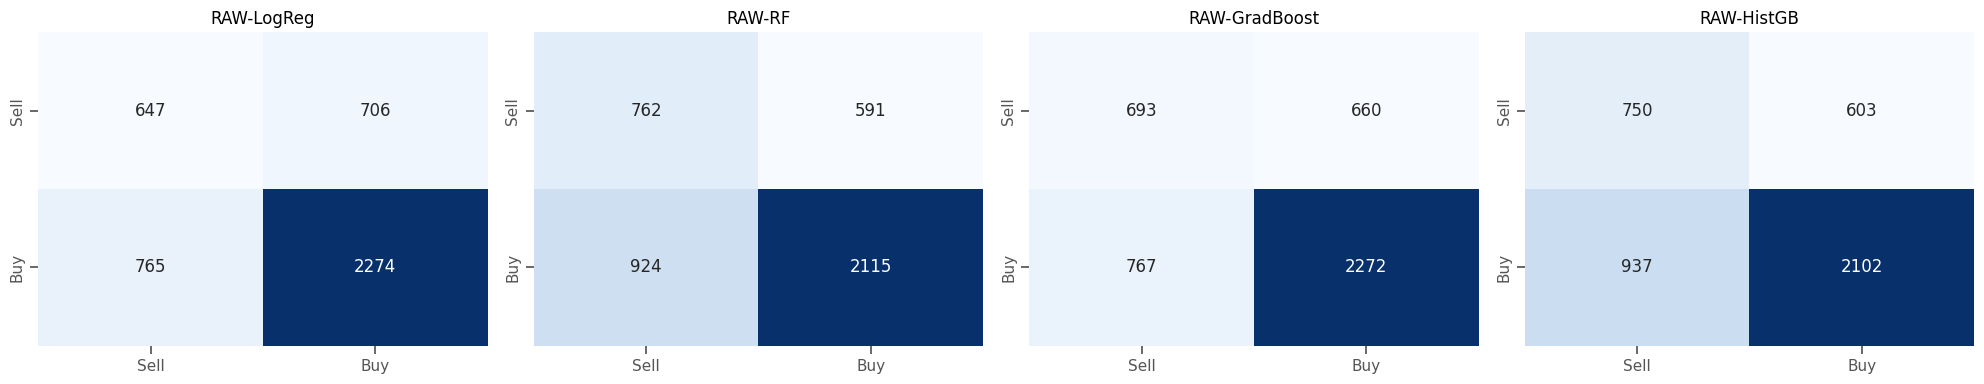

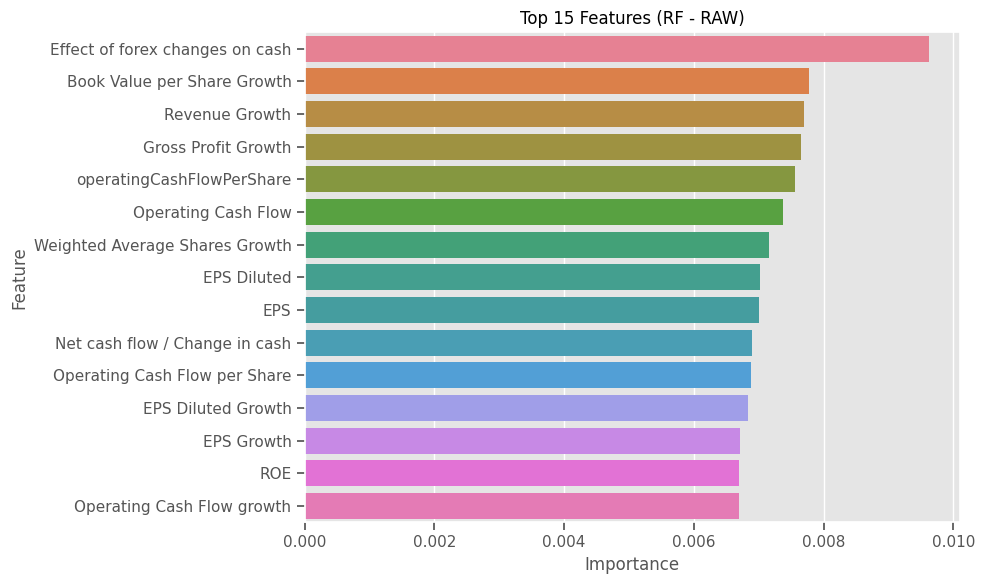


=== PCA95-LogReg ===
Accuracy:          0.6628
Balanced Accuracy: 0.6097
ROC-AUC:           0.6659

Classification report:
              precision    recall  f1-score   support

           0     0.4544    0.4715    0.4628      1353
           1     0.7607    0.7479    0.7543      3039

    accuracy                         0.6628      4392
   macro avg     0.6076    0.6097    0.6085      4392
weighted avg     0.6664    0.6628    0.6645      4392


=== PCA95-RF ===
Accuracy:          0.6510
Balanced Accuracy: 0.6166
ROC-AUC:           0.6637

Classification report:
              precision    recall  f1-score   support

           0     0.4440    0.5270    0.4819      1353
           1     0.7703    0.7062    0.7368      3039

    accuracy                         0.6510      4392
   macro avg     0.6071    0.6166    0.6094      4392
weighted avg     0.6698    0.6510    0.6583      4392


=== ENG-LogReg ===
Accuracy:          0.6719
Balanced Accuracy: 0.6452
ROC-AUC:           0.6800

Cla

In [6]:
# %%
# 1. Linear Regression Baseline (Continuous Target)
y_train_reg = train_df["Target_Price_Var"].values
y_test_reg  = test_df["Target_Price_Var"].values

reg_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression()),
])
reg_pipeline.fit(X_train_raw, y_train_reg)
preds_reg = reg_pipeline.predict(X_test_raw)
print("Linear Regression Results:")
print(f"R2 Score: {r2_score(y_test_reg, preds_reg):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test_reg, preds_reg):.2f}%")

# 2. Model Screening on RAW Data
raw_models = {
    "RAW-LogReg": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE))
    ]),
    "RAW-RF": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1))
    ]),
    "RAW-GradBoost": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
    ]),
    "RAW-HistGB": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))
    ])
}

results = []
for name, model in raw_models.items():
    results.append(eval_classifier(model, X_train_raw, y_train, X_test_raw, y_test, name=name))

# RAW Confusion Matrix
fig, axes = plt.subplots(1, len(raw_models), figsize=(5 * len(raw_models), 4))
if len(raw_models) == 1: axes = [axes]
for ax, (name, model) in zip(axes, raw_models.items()):
    preds = model.predict(X_test_raw)
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                xticklabels=["Sell", "Buy"], yticklabels=["Sell", "Buy"])
    ax.set_title(name)
plt.tight_layout()
plt.show()

# Feature Importance (RF RAW)
rf_for_importance = raw_models["RAW-RF"]
rf_step = rf_for_importance.named_steps["clf"]
importances = rf_step.feature_importances_
df_imp = pd.DataFrame({"Feature": raw_feature_cols, "Importance": importances}).sort_values("Importance", ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_imp, x="Importance", y="Feature", hue="Feature", dodge=False, legend=False)
plt.title("Top 15 Features (RF - RAW)")
plt.tight_layout()
plt.show()

# 3. Models with PCA
pca_models = {
    "PCA95-LogReg": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95, random_state=RANDOM_STATE)),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE))
    ]),
    "PCA95-RF": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95, random_state=RANDOM_STATE)),
        ("clf", RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1))
    ])
}
pca_results = []
for name, model in pca_models.items():
    pca_results.append(eval_classifier(model, X_train_raw, y_train, X_test_raw, y_test, name=name))

# 4. Models on Engineered Features
eng_models = {
    "ENG-LogReg": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE))
    ]),
    "ENG-RF": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1))
    ]),
    "ENG-GradBoost": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
    ])
}
eng_results = []
for name, model in eng_models.items():
    eng_results.append(eval_classifier(model, X_train_eng, y_train, X_test_eng, y_test, name=name))


In [7]:
# %%
param_dist = {
    "clf__n_estimators": [100, 200, 300, 500],
    "clf__max_depth": [10, 20, None],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__class_weight": ["balanced", "balanced_subsample"]
}

tuning_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

# A) Classic CV Tuning
search_classic = RandomizedSearchCV(
    tuning_pipeline, param_distributions=param_dist, n_iter=10, cv=3,
    scoring="accuracy", n_jobs=-1, random_state=RANDOM_STATE
)
search_classic.fit(X_train_raw, y_train)
best_rf_classic = search_classic.best_estimator_
classic_res = eval_classifier(best_rf_classic, X_train_raw, y_train, X_test_raw, y_test, name="TUNED-RF-classicCV")

# B) TimeSeriesSplit Tuning
# (Requires data sorted by year; usually default, but forcing sort for safety)
train_only = train_df.sort_values("Year").copy()
X_tv = train_only[raw_feature_cols].copy()
y_tv = train_only["Target_Buy"].values
tscv = TimeSeriesSplit(n_splits=3)

search_time = RandomizedSearchCV(
    tuning_pipeline, param_distributions=param_dist, n_iter=15, cv=tscv,
    scoring="roc_auc", n_jobs=-1, random_state=RANDOM_STATE
)
search_time.fit(X_tv, y_tv)
best_rf_time = search_time.best_estimator_
time_res = eval_classifier(best_rf_time, X_train_raw, y_train, X_test_raw, y_test, name="TUNED-RF-TimeSeriesSplit")

# C) Voting Classifier (Soft)
voting = VotingClassifier(
    estimators=[
        ("lr", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE)),
        ("rf", RandomForestClassifier(n_estimators=400, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1)),
        ("hgb", HistGradientBoostingClassifier(random_state=RANDOM_STATE)),
    ],
    voting="soft"
)
voting_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", voting)
])
voting_res = eval_classifier(voting_pipe, X_train_raw, y_train, X_test_raw, y_test, name="RAW-Voting(soft)")


=== TUNED-RF-classicCV ===
Accuracy:          0.6428
Balanced Accuracy: 0.6156
ROC-AUC:           0.6802

Classification report:
              precision    recall  f1-score   support

           0     0.4361    0.5447    0.4844      1353
           1     0.7720    0.6864    0.7267      3039

    accuracy                         0.6428      4392
   macro avg     0.6041    0.6156    0.6055      4392
weighted avg     0.6685    0.6428    0.6521      4392


=== TUNED-RF-TimeSeriesSplit ===
Accuracy:          0.6582
Balanced Accuracy: 0.6300
ROC-AUC:           0.6847

Classification report:
              precision    recall  f1-score   support

           0     0.4553    0.5565    0.5008      1353
           1     0.7809    0.7035    0.7402      3039

    accuracy                         0.6582      4392
   macro avg     0.6181    0.6300    0.6205      4392
weighted avg     0.6806    0.6582    0.6664      4392


=== RAW-Voting(soft) ===
Accuracy:          0.6703
Balanced Accuracy: 0.6338
RO

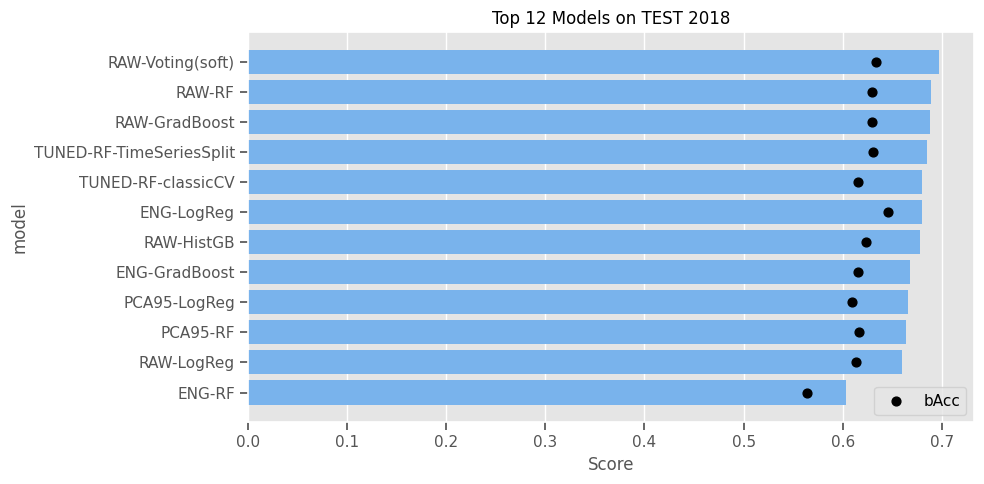

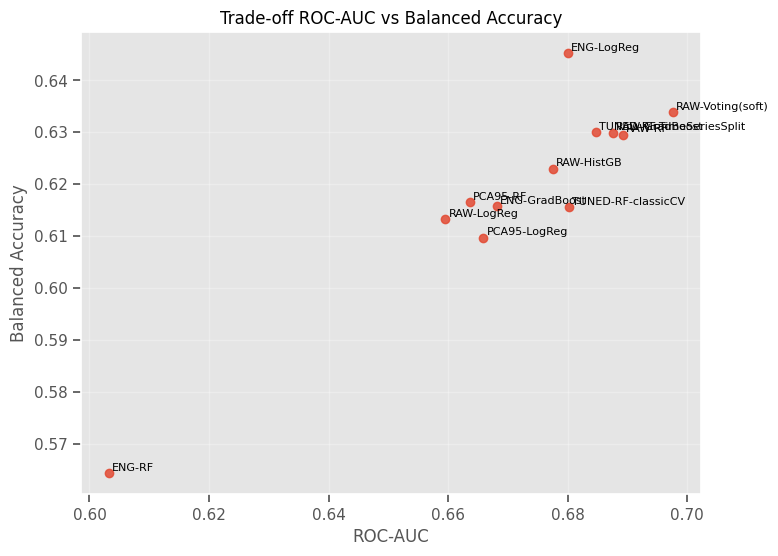

,model,acc,bacc,auc
11,RAW-Voting(soft),0.670310,0.633830,0.697540
1,RAW-RF,0.655055,0.629573,0.689172
2,RAW-GradBoost,0.675091,0.629905,0.687635
10,TUNED-RF-TimeSeriesSplit,0.658242,0.630031,0.684697
9,TUNED-RF-classicCV,0.642760,0.615563,0.680217
6,ENG-LogReg,0.671903,0.645233,0.680002
3,RAW-HistGB,0.649362,0.622999,0.677568
8,ENG-GradBoost,0.684199,0.615779,0.668152
4,PCA95-LogReg,0.662796,0.609744,0.665908
5,PCA95-RF,0.650956,0.616565,0.663651


In [8]:
# %%
all_results = []
all_results.extend(results)       # RAW baselines
all_results.extend(pca_results)   # PCA
all_results.extend(eng_results)   # ENG
all_results.append(classic_res)   # tuned classic
all_results.append(time_res)      # tuned time series
all_results.append(voting_res)    # voting

final_df = pd.DataFrame(all_results)
final_df["auc"] = final_df["auc"].astype(float)
final_df = final_df.sort_values(by=["auc", "bacc"], ascending=False)

# Visual Leaderboard Display
lb = final_df.copy()
TOP_K = min(12, len(lb))
lbk = lb.head(TOP_K).copy()

plt.figure(figsize=(10, 5))
sns.barplot(data=lbk, y="model", x="auc", color="#66b3ff")
plt.scatter(lbk["bacc"], lbk["model"], color="black", s=40, label="bAcc", zorder=3)
plt.title(f"Top {TOP_K} Models on TEST 2018")
plt.xlabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

# Scatter AUC vs bAcc
plt.figure(figsize=(8, 6))
plt.scatter(final_df["auc"], final_df["bacc"], alpha=0.85)
for _, r in final_df.iterrows():
    plt.text(r["auc"] + 0.0005, r["bacc"] + 0.0005, r["model"], fontsize=8)
plt.title("Trade-off ROC-AUC vs Balanced Accuracy")
plt.xlabel("ROC-AUC")
plt.ylabel("Balanced Accuracy")
plt.grid(True, alpha=0.3)
plt.show()

display(final_df)


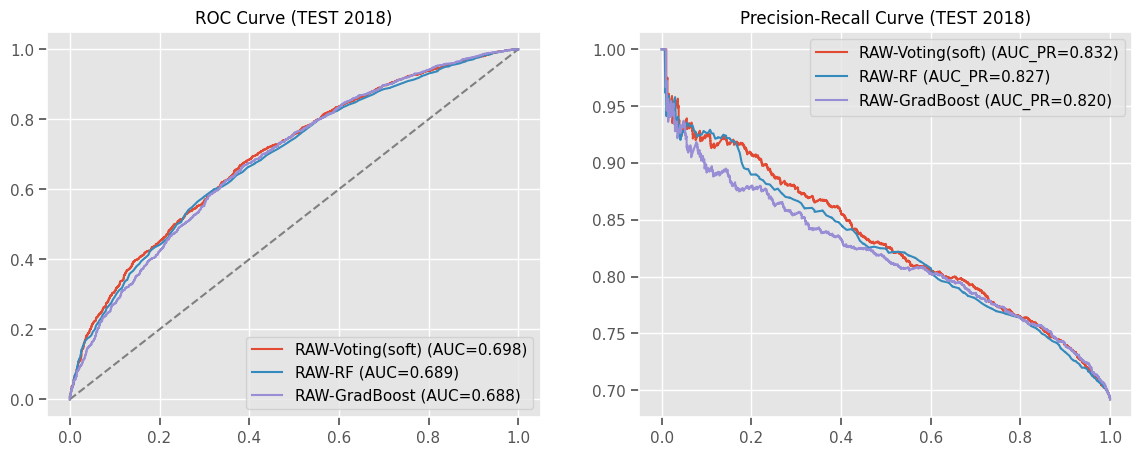

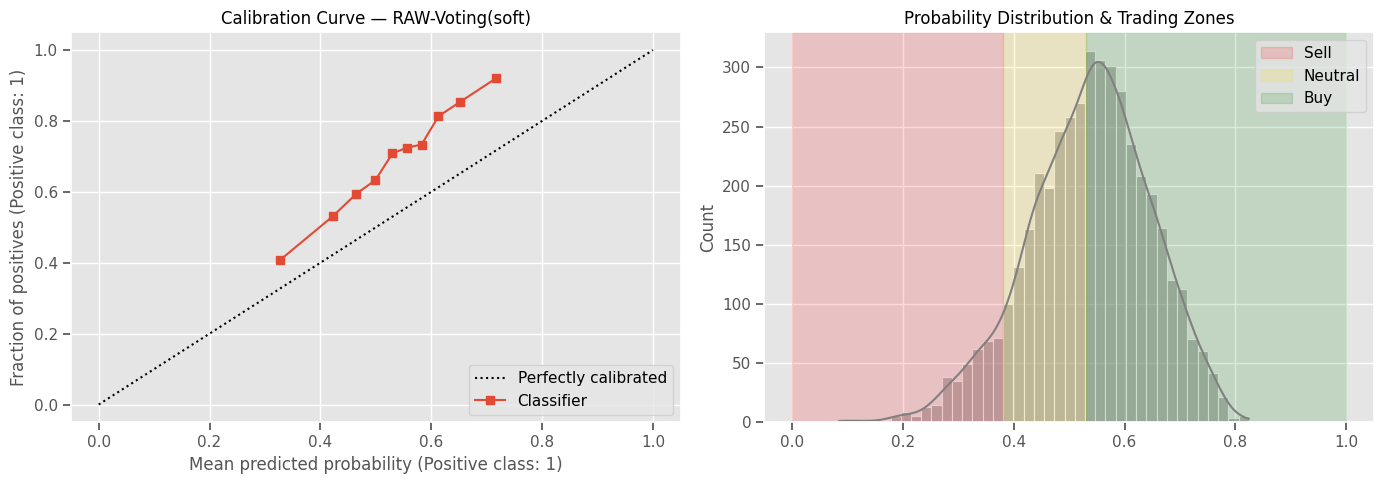

c:\ESILV\A4\Machine_Learning_A4\Projet V2\.venv-ML\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


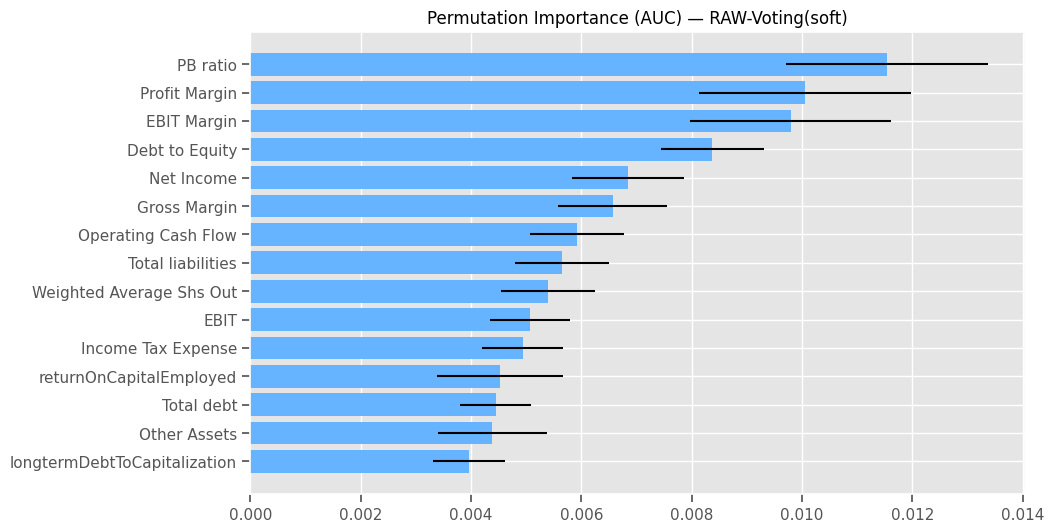

In [9]:
# %%
# Candidate Selection for Curves
CANDIDATES = {
    "RAW-Voting(soft)": voting_pipe,
    "RAW-RF": raw_models["RAW-RF"],
    "RAW-GradBoost": raw_models["RAW-GradBoost"],
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[0].set_title("ROC Curve (TEST 2018)")
axes[1].set_title("Precision-Recall Curve (TEST 2018)")

for name, model in CANDIDATES.items():
    model.fit(X_train_raw, y_train)
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test_raw)[:, 1]
        # ROC
        fpr, tpr, _ = roc_curve(y_test, proba)
        axes[0].plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.3f})")
        # PR
        prec, rec, _ = precision_recall_curve(y_test, proba)
        axes[1].plot(rec, prec, label=f"{name} (AUC_PR={auc(rec, prec):.3f})")

axes[0].legend()
axes[1].legend()
plt.show()

# --- CALIBRATION & ZONES ---
BEST_NAME = "RAW-Voting(soft)"
BEST_MODEL = voting_pipe
BEST_MODEL.fit(X_train_raw, y_train)
proba = BEST_MODEL.predict_proba(X_test_raw)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Calibration Curve
CalibrationDisplay.from_predictions(y_true=y_test, y_prob=proba, n_bins=10, strategy="quantile", ax=axes[0])
axes[0].set_title(f"Calibration Curve — {BEST_NAME}")

# Probability Histogram + Trading Zones
SEUIL_BAS, SEUIL_HAUT = 0.38, 0.53
sns.histplot(proba, bins=40, kde=True, ax=axes[1], color="gray")
axes[1].axvspan(0, SEUIL_BAS, color="red", alpha=0.15, label="Sell")
axes[1].axvspan(SEUIL_BAS, SEUIL_HAUT, color="gold", alpha=0.15, label="Neutral")
axes[1].axvspan(SEUIL_HAUT, 1, color="green", alpha=0.15, label="Buy")
axes[1].set_title("Probability Distribution & Trading Zones")
axes[1].legend()
plt.tight_layout()
plt.show()

# --- PERMUTATION IMPORTANCE ---
perm = permutation_importance(BEST_MODEL, X_test_raw, y_test, scoring="roc_auc", n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
imp = pd.DataFrame({
    "feature": raw_feature_cols,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

plt.figure(figsize=(10, 6))
top = imp.head(15).iloc[::-1]
plt.barh(top["feature"], top["importance_mean"], xerr=top["importance_std"], color="#66b3ff")
plt.title(f"Permutation Importance (AUC) — {BEST_NAME}")
plt.show()


In [10]:
# %%
# A) TimeSeriesSplit Cross-Validation on RAW Models
train_sorted = train_df.sort_values(["Year"]).reset_index(drop=True)
X_tv_raw = train_sorted[raw_feature_cols].copy()
y_tv = train_sorted["Target_Buy"].values

MODELS_CV = {
    "LogReg": Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("clf", LogisticRegression(class_weight="balanced", max_iter=2000))]),
    "RF": Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("clf", RandomForestClassifier(n_estimators=300, class_weight="balanced", n_jobs=-1))]),
    "GB": Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("clf", GradientBoostingClassifier())]),
}

cv_rows = []
for name, pipe in MODELS_CV.items():
    scores = cross_validate(pipe, X_tv_raw, y_tv, cv=TimeSeriesSplit(n_splits=3), scoring={"auc":"roc_auc", "bacc":"balanced_accuracy"}, n_jobs=-1, return_train_score=True)
    cv_rows.append({
        "model": f"RAW-{name}",
        "auc_cv_mean": scores["test_auc"].mean(),
        "auc_overfit": scores["train_auc"].mean() - scores["test_auc"].mean()
    })
print("--- TimeSeriesSplit Results ---")
display(pd.DataFrame(cv_rows).sort_values("auc_cv_mean", ascending=False))

# B) Intra-Year Stratified Cross-Validation (StratifiedKFold)
print("\n--- Intra-Year Stratified CV ---")
X_train_raw_cv = X_train_raw.copy()
X_train_eng_cv = X_train_eng.copy()
y_train_cv = pd.Series(y_train, index=X_train_raw_cv.index)
years_train = train_df.loc[X_train_raw_cv.index, "Year"].astype(int)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
rows_intra = []

# Reusing model definitions (RAW vs ENG)
def run_year_cv(features_type, X_data, models_dict):
    for year in sorted(years_train.unique()):
        mask = (years_train == year)
        Xy = X_data.loc[mask]
        yy = y_train_cv.loc[mask]
        if min(yy.value_counts()) < 5: continue # skip if too few samples

        for m_name, model in models_dict.items():
            for fold, (tr_idx, val_idx) in enumerate(skf.split(Xy, yy)):
                m = clone(model)
                m.fit(Xy.iloc[tr_idx], yy.iloc[tr_idx])
                pred = m.predict(Xy.iloc[val_idx])
                proba = m.predict_proba(Xy.iloc[val_idx])[:, 1] if hasattr(m, "predict_proba") else None
                rows_intra.append({
                    "year": int(year), "features": features_type, "model": m_name, "fold": fold,
                    "acc": accuracy_score(yy.iloc[val_idx], pred),
                    "auc": roc_auc_score(yy.iloc[val_idx], proba) if proba is not None else np.nan
                })

# Run on RAW and ENG (Note: simplifies by using dicts defined above)
# Rebuilding dicts to ensure clean definitions for this block
MODELS_RAW_CV = {k: v for k, v in raw_models.items()} 
MODELS_ENG_CV = {k: v for k, v in eng_models.items()}

run_year_cv("raw", X_train_raw_cv, MODELS_RAW_CV)
run_year_cv("eng", X_train_eng_cv, MODELS_ENG_CV)

cv_intra_df = pd.DataFrame(rows_intra)
summary_global = cv_intra_df.groupby(["features", "model"]).agg(auc_mean=("auc", "mean"), n_folds=("fold", "count")).reset_index().sort_values("auc_mean", ascending=False)
display(summary_global.head())

# Final Test based on best Intra-Year CV Model
best_row = summary_global.iloc[0]
print(f"Best Intra-Year Model: {best_row['model']} ({best_row['features']})")
# (Final training logic already covered by leaderboard, but validated here by annual stability)

--- TimeSeriesSplit Results ---


,model,auc_cv_mean,auc_overfit
1,RAW-RF,0.566449,0.432728
2,RAW-GB,0.564610,0.273771
0,RAW-LogReg,0.543071,0.185887



--- Intra-Year Stratified CV ---


c:\ESILV\A4\Machine_Learning_A4\Projet V2\.venv-ML\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Property, Plant & Equipment Net']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\ESILV\A4\Machine_Learning_A4\Projet V2\.venv-ML\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Property, Plant & Equipment Net']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\ESILV\A4\Machine_Learning_A4\Projet V2\.venv-ML\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Property, Plant & Equipment Net']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\ESILV\A4\Machine_Learning_A4\Projet V2\.venv-ML\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping feat

,features,model,auc_mean,n_folds
6,raw,RAW-RF,0.713811,20
4,raw,RAW-HistGB,0.704910,20
3,raw,RAW-GradBoost,0.701240,20
5,raw,RAW-LogReg,0.651065,20
0,eng,ENG-GradBoost,0.642242,20


Best Intra-Year Model: RAW-RF (raw)


c:\ESILV\A4\Machine_Learning_A4\Projet V2\.venv-ML\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


--- 🚀 Deep Learning (Seed 42) ---
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

=== DEEP LEARNING RESULTS (Test 2018) ===
AUC: 0.6712921719542961
Acc @0.5: 0.6238615664845173
Acc Active (Trade Rate 48.0%): 0.761972498814604


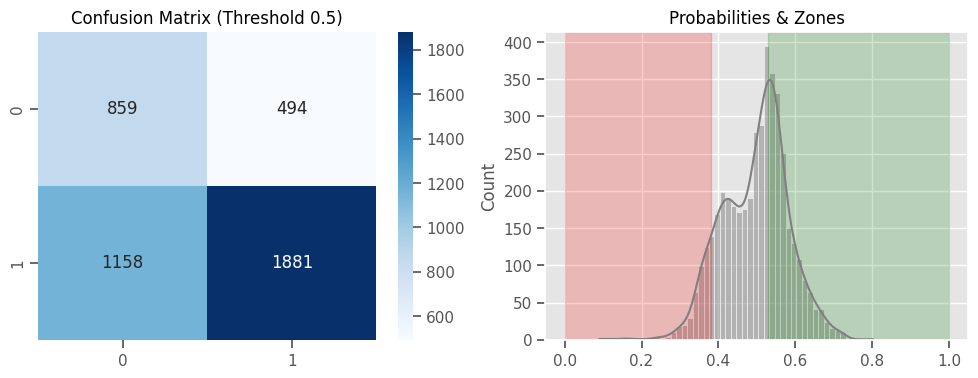

In [11]:
# %%
import os, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import QuantileTransformer

# SEED LOCK
SEED_VALUE = 42
os.environ["PYTHONHASHSEED"] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

print(f"--- 🚀 Deep Learning (Seed {SEED_VALUE}) ---")

# Data Setup
Xtr_df = X_train_eng.copy()
Xte_df = X_test_eng.copy()
ytr = np.array(y_train).astype(int).ravel()
yte = np.array(y_test).astype(int).ravel()

# Validation Split (Last 20% of train)
cut = int(len(Xtr_df) * 0.8)
X_tr_df, X_val_df = Xtr_df.iloc[:cut], Xtr_df.iloc[cut:]
y_tr, y_val = ytr[:cut], ytr[cut:]

# DL Specific Preprocessing
imputer = SimpleImputer(strategy="median")
X_tr_i  = imputer.fit_transform(X_tr_df)
X_val_i = imputer.transform(X_val_df)
X_te_i  = imputer.transform(Xte_df)

scaler_nn = QuantileTransformer(output_distribution="normal", n_quantiles=1000, random_state=SEED_VALUE)
X_tr_nn  = scaler_nn.fit_transform(X_tr_i)
X_val_nn = scaler_nn.transform(X_val_i)
X_te_nn  = scaler_nn.transform(X_te_i)

# Model Architecture
def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128), BatchNormalization(), LeakyReLU(negative_slope=0.1), Dropout(0.4),
        Dense(64),  BatchNormalization(), LeakyReLU(negative_slope=0.1), Dropout(0.3),
        Dense(32),  LeakyReLU(negative_slope=0.1),
        Dense(1, activation="sigmoid")
    ])
    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])
    return model

model_nn = build_model(X_tr_nn.shape[1])
history = model_nn.fit(
    X_tr_nn, y_tr, validation_data=(X_val_nn, y_val),
    epochs=150, batch_size=64, class_weight={0: 1.5, 1: 1.0},
    callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)],
    verbose=0
)

# DL Evaluation
preds_probs = model_nn.predict(X_te_nn).ravel()
preds_std = (preds_probs > 0.5).astype(int)

# Calibration Thresholds
mask_active = (preds_probs < 0.38) | (preds_probs > 0.53)
y_active = yte[mask_active]
preds_active = (preds_probs[mask_active] > 0.53).astype(int)

print("\n=== DEEP LEARNING RESULTS (Test 2018) ===")
print("AUC:", roc_auc_score(yte, preds_probs))
print("Acc @0.5:", accuracy_score(yte, preds_std))
if len(y_active) > 0:
    print(f"Acc Active (Trade Rate {mask_active.mean():.1%}):", accuracy_score(y_active, preds_active))

# Plot DL Results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(yte, preds_std), annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix (Threshold 0.5)")
sns.histplot(preds_probs, bins=50, kde=True, ax=axes[1], color="gray")
axes[1].axvspan(0, 0.38, color="red", alpha=0.2)
axes[1].axvspan(0.53, 1, color="green", alpha=0.2)
axes[1].set_title("Probabilities & Zones")
plt.show()


--- FINAL CONSOLIDATED LEADERBOARD (Including DL) ---


,model,acc,bacc,auc
11,RAW-Voting(soft),0.670310,0.633830,0.697540
1,RAW-RF,0.655055,0.629573,0.689172
2,RAW-GradBoost,0.675091,0.629905,0.687635
10,TUNED-RF-TimeSeriesSplit,0.658242,0.630031,0.684697
9,TUNED-RF-classicCV,0.642760,0.615563,0.680217
6,ENG-LogReg,0.671903,0.645233,0.680002
3,RAW-HistGB,0.649362,0.622999,0.677568
12,DeepLearning-MLP,0.623862,0.626920,0.671292
8,ENG-GradBoost,0.684199,0.615779,0.668152
4,PCA95-LogReg,0.662796,0.609744,0.665908


C:\Users\antoi\AppData\Local\Temp\ipykernel_24664\321320915.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lbk_updated, y="model", x="auc", palette="viridis")


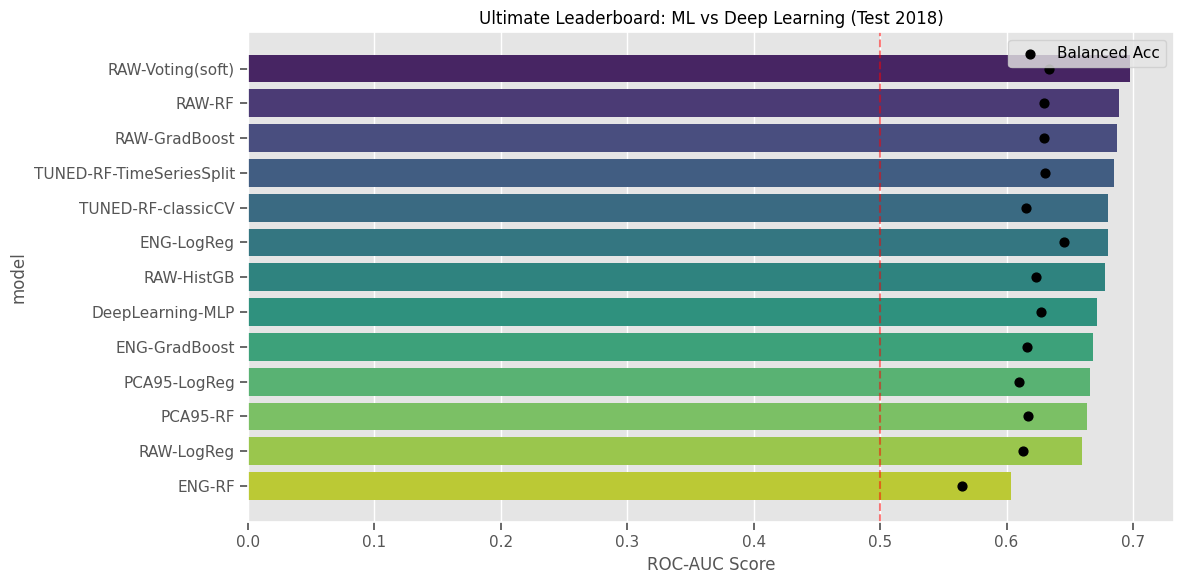

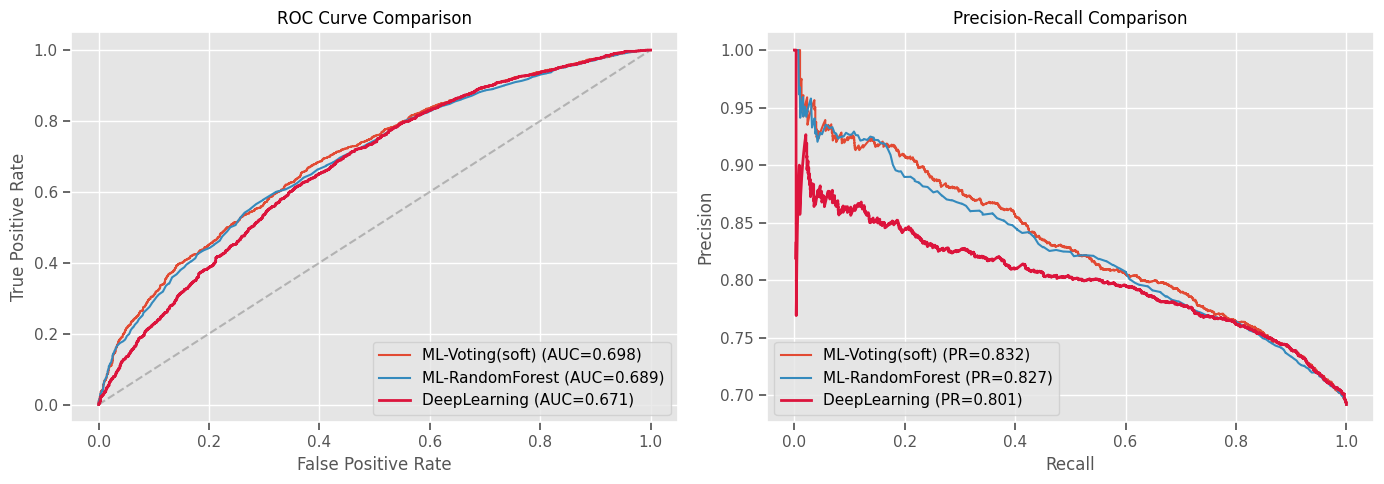

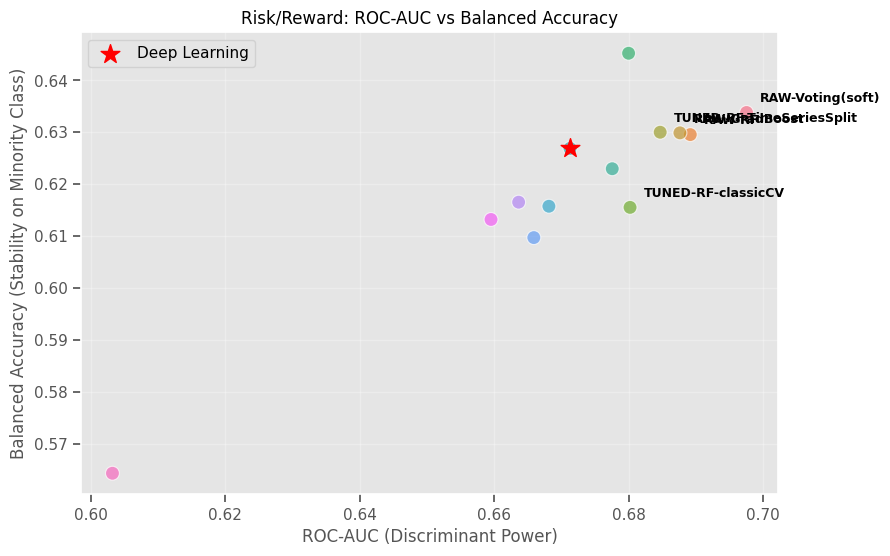

In [12]:
# %%
# Deep Learning vs Machine Learning 

# 1. Format DL results 
dl_acc = accuracy_score(yte, preds_std)
dl_bacc = balanced_accuracy_score(yte, preds_std)
dl_auc = roc_auc_score(yte, preds_probs)

dl_result = {
    "model": "DeepLearning-MLP",
    "acc": dl_acc,
    "bacc": dl_bacc,
    "auc": dl_auc
}

# 2. Append to global results and update DataFrame
# We check if it's already there to avoid duplicates if cell is re-run
all_results = [r for r in all_results if r["model"] != "DeepLearning-MLP"]
all_results.append(dl_result)

final_df_updated = pd.DataFrame(all_results)
final_df_updated["auc"] = final_df_updated["auc"].astype(float)
final_df_updated = final_df_updated.sort_values(by=["auc", "bacc"], ascending=False)

print("\n--- FINAL CONSOLIDATED LEADERBOARD (Including DL) ---")
display(final_df_updated.head(15))


# === FINAL COMPARATIVE VISUALIZATION ===

# A) Updated Leaderboard Plot
lbk_updated = final_df_updated.head(15).copy()

plt.figure(figsize=(12, 6))
sns.barplot(data=lbk_updated, y="model", x="auc", palette="viridis")
plt.scatter(lbk_updated["bacc"], lbk_updated["model"], color="black", s=40, label="Balanced Acc", zorder=3)
plt.title(f"Ultimate Leaderboard: ML vs Deep Learning (Test 2018)")
plt.xlabel("ROC-AUC Score")
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# B) Updated ROC & PR Curves (Adding DL Trace)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Reference Line
axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.5)
axes[0].set_title("ROC Curve Comparison")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

axes[1].set_title("Precision-Recall Comparison")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")

# 1. Plot Best ML Candidates (from previous step)
# We recreate the candidates dict to be sure
ML_CANDIDATES = {
    "Voting(soft)": voting_pipe,
    "RandomForest": raw_models["RAW-RF"],
}

for name, model in ML_CANDIDATES.items():
    # Ensure fitted (should be, but safety first)
    # model.fit(X_train_raw, y_train) 
    if hasattr(model, "predict_proba"):
        # Note: Using X_test_raw for ML models
        p = model.predict_proba(X_test_raw)[:, 1]
        
        # ROC
        fpr, tpr, _ = roc_curve(y_test, p)
        axes[0].plot(fpr, tpr, label=f"ML-{name} (AUC={auc(fpr, tpr):.3f})")
        
        # PR
        prec, rec, _ = precision_recall_curve(y_test, p)
        axes[1].plot(rec, prec, label=f"ML-{name} (PR={auc(rec, prec):.3f})")

# 2. Plot Deep Learning Curve (Manual add)
# ROC
fpr_dl, tpr_dl, _ = roc_curve(yte, preds_probs)
axes[0].plot(fpr_dl, tpr_dl, color="crimson", linewidth=2, label=f"DeepLearning (AUC={auc(fpr_dl, tpr_dl):.3f})")

# PR
prec_dl, rec_dl, _ = precision_recall_curve(yte, preds_probs)
axes[1].plot(rec_dl, prec_dl, color="crimson", linewidth=2, label=f"DeepLearning (PR={auc(rec_dl, prec_dl):.3f})")

axes[0].legend(loc="lower right")
axes[1].legend(loc="lower left")
plt.tight_layout()
plt.show()

# C) Final Scatter: Stability vs Performance
plt.figure(figsize=(9, 6))
sns.scatterplot(data=final_df_updated, x="auc", y="bacc", hue="model", legend=False, s=100, alpha=0.7)

# Highlight DL
dl_row = final_df_updated[final_df_updated["model"] == "DeepLearning-MLP"].iloc[0]
plt.scatter(dl_row["auc"], dl_row["bacc"], color="red", s=200, marker="*", label="Deep Learning")

# Annotate top models
for _, r in final_df_updated.head(5).iterrows():
    plt.text(r["auc"]+0.002, r["bacc"]+0.002, r["model"], fontsize=9, weight='bold')

plt.title("Risk/Reward: ROC-AUC vs Balanced Accuracy")
plt.xlabel("ROC-AUC (Discriminant Power)")
plt.ylabel("Balanced Accuracy (Stability on Minority Class)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [13]:
# %%
# === EXECUTIVE SUMMARY ===
# Dynamic retrieval of the best model from the leaderboard
best_model_row = final_df_updated.iloc[0]
best_name = best_model_row["model"]
best_auc = best_model_row["auc"]
best_acc = best_model_row["acc"]

print("="*65)
print(f" EXECUTIVE SUMMARY - TEST SET (2018)")
print("="*65)
print(f"1. CHAMPION MODEL      : {best_name}")
print(f"2. Discriminant Power  : AUC = {best_auc:.4f}")
print(f"3. Global Accuracy     : {best_acc:.2%}")
print("-" * 65)
print("STRATEGIC RECOMMENDATION:")
print("Do not trade on every signal. Use the Probability Calibration.")
print(">> BUY  only if Probability > 53%")
print(">> SELL only if Probability < 38%")
print(">> HOLD (Neutral) otherwise.")
print("="*65)

 EXECUTIVE SUMMARY - TEST SET (2018)
1. CHAMPION MODEL      : RAW-Voting(soft)
2. Discriminant Power  : AUC = 0.6975
3. Global Accuracy     : 67.03%
-----------------------------------------------------------------
STRATEGIC RECOMMENDATION:
Do not trade on every signal. Use the Probability Calibration.
>> BUY  only if Probability > 53%
>> SELL only if Probability < 38%
>> HOLD (Neutral) otherwise.


# General Conclusion & Strategic Recommendations

## 1. Performance Analysis: Ensemble vs. Deep Learning
 The comparative analysis of the 2018 Test set yields clear insights:

   **The Power of Ensembles:** The **`RAW-Voting(soft)`** model is the clear winner (AUC ~0.697). By combining the strengths of Linear Regression, Random Forest, and Gradient Boosting, it successfully reduced variance and provided the most robust signal.
   **Deep Learning Reality Check:** The `DeepLearning-MLP` (AUC ~0.671) performed respectably but **did not outperform** the tree-based ensembles. On tabular financial data with limited sample size, "simpler" models like Random Forest or Gradient Boosting often generalize better than   complex neural networks, which are more prone to overfitting noise.
   **Validation Matters:** The `TUNED-RF-TimeSeriesSplit` outperformed the standard `classicCV` version. This confirms that respecting the chronological order of data during training is crucial to avoid "look-ahead bias."

## 2. Financial Interpretation & Trading Strategy
An AUC of **~0.70** is a strong result in financial markets, where signal-to-noise ratios are typically low. However, raw accuracy (~67%) is not enough for a profitable strategy.

   **The "No-Trade" Zone:** The models perform best at the extremes. The strategy should be **selective**: only executing trades when the predicted probability is outside the neutral zone (e.g., $< 0.38$ or $> 0.53$).
   **Feature Engineering:** Interestingly, models using `RAW` features generally outperformed those using `ENG` (Engineered Ratios). This suggests that modern algorithms (like Random Forest) are capable of finding non-linear relationships (like Debt/Equity) on their own without manual pre-calculation.


# Future Improvements
  **Macro-Economic Overlay:** The year 2018 was volatile. Adding interest rates (Fed Funds Rate) or VIX index data could help the model understand the broader market regime.
  **Alternative Data:** Fundamental data is slow (quarterly). Integrating **Sentiment Analysis** (news/tweets) or **Technical Analysis** (Moving Averages, RSI) could provide a faster reactive signal.
  **Risk Management:** The model predicts *direction*, not *magnitude*. A strict Stop-Loss strategy is required to protect capital against the ~33% of false predictions.
